# Installing Dataset

Please add your Kaggle API key to the google colab or

Place your Kaggle.json file in the file path:'/root/.config/kaggle/' before running the following code cells

In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c sp-25-tamu-csce-633-600-machine-learning

sp-25-tamu-csce-633-600-machine-learning.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip sp-25-tamu-csce-633-600-machine-learning.zip

Archive:  sp-25-tamu-csce-633-600-machine-learning.zip
replace cgm_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cgm_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace demo_viome_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace demo_viome_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace img_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace img_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace label_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Importing Modules

In [ ]:
import os
import copy
import pandas as pd
import numpy as np
import cv2
import ast
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# Dataset Preprocessing

## CGM Data Preprocessing

This class processes Continuous Glucose Monitoring (CGM) data and prepares it for analysis
or machine learning applications.

**Key functionality:**

- Loads and parses CGM data from CSV files
- Extracts time series data and glucose values
- Normalizes glucose values
- Calculates statistical features (mean, max, min, std)
- Analyzes meal responses (breakfast and lunch windows)
- Computes glucose rate of change features
- Optionally pads sequences to uniform length
- Merges with optional label data

**Usage example:**

```python
preprocessor = CGMPreprocessor('cgm_data.csv', 'labels.csv')
processed_df = preprocessor.get_processed_data()
```

In [ ]:
class CGMPreprocessor:
    def __init__(self, cgm_path, label_path=None, pad_sequences=True):
        """
        Initialize the CGMPreprocessor.
        Args:
            cgm_path (str): Path to the CSV file containing CGM data.
            label_path (str, optional): Path to the CSV file containing labels.
            pad_sequences (bool, optional): Whether to pad sequences to the same length.
        """
        self.df = pd.read_csv(cgm_path)
        self.label_path = label_path
        self.pad_sequences = pad_sequences
        self.max_seq_len = 0  # Will be set during processing
        self._process_raw_data()

    def _process_raw_data(self):
        """
        Core processing pipeline for CGM data.
        """
        # Parse CGM data
        self.df['CGM Data'] = self.df['CGM Data'].apply(self._convert_cgm_data)
        self.df = self.df[self.df['CGM Data'].apply(lambda x: len(x) > 0)]

        # Extract times and values
        self.df[['CGM Times', 'CGM Values']] = self.df['CGM Data'].apply(
            lambda x: pd.Series(self._extract_times_and_values(x))
        )

        # Convert time columns
        self.df['Breakfast Time'] = pd.to_datetime(self.df['Breakfast Time'], errors='coerce').dt.time
        self.df['Lunch Time'] = pd.to_datetime(self.df['Lunch Time'], errors='coerce').dt.time
        self.df['CGM Times'] = self.df['CGM Times'].apply(
            lambda times: [pd.to_datetime(t).time() for t in times]
        )

        # Drop raw column
        self.df.drop(columns=['CGM Data'], inplace=True)

        # Basic stats
        self.df['CGM Mean'] = self.df['CGM Values'].apply(np.mean)
        self.df['CGM Max'] = self.df['CGM Values'].apply(np.max)
        self.df['CGM Min'] = self.df['CGM Values'].apply(np.min)
        self.df['CGM Std'] = self.df['CGM Values'].apply(np.std)

        # Meal-based features
        self.df['Breakfast Response'] = self.df.apply(
            lambda row: self._meal_window_values(row['CGM Times'], row['CGM Values'], row['Breakfast Time']), axis=1
        )
        self.df['Lunch Response'] = self.df.apply(
            lambda row: self._meal_window_values(row['CGM Times'], row['CGM Values'], row['Lunch Time']), axis=1
        )
        self.df['Breakfast AUC'] = self.df['Breakfast Response'].apply(np.sum)
        self.df['Lunch AUC'] = self.df['Lunch Response'].apply(np.sum)

        # Glucose rate of change
        self.df['CGM Derivatives'] = self.df['CGM Values'].apply(lambda x: np.diff(x).tolist())
        self.df['CGM ROC Mean'] = self.df['CGM Derivatives'].apply(lambda x: np.mean(x) if len(x) else 0)
        self.df['CGM ROC Max'] = self.df['CGM Derivatives'].apply(lambda x: np.max(x) if len(x) else 0)

        # Normalization
        self.df['CGM Values Norm'] = self.df.groupby('Subject ID')['CGM Values'].transform(self._normalize_series)

        # Padding if needed
        if self.pad_sequences:
            self.max_seq_len = self.df['CGM Values Norm'].apply(len).max()
            self.df['CGM Values Norm'] = self.df['CGM Values Norm'].apply(
                lambda x: x + [0.0] * (self.max_seq_len - len(x))
            )

        # Merge with labels if provided
        if self.label_path:
            labels = pd.read_csv(self.label_path)
            self.df = self.df.merge(labels, on=['Subject ID', 'Day'], how='inner')

    def _convert_cgm_data(self, cgm_string):
        """
        Convert CGM data string to list of tuples.
        Args:
            cgm_string (str): String representation of CGM data.
        Returns:
            list: List of tuples (time, value).
        """
        try:
            return ast.literal_eval(cgm_string)
        except (SyntaxError, ValueError):
            return []

    def _extract_times_and_values(self, cgm_data):
        """
        Extract timestamps and values from CGM data.
        Args:
            cgm_data (list): List of tuples (time, value).
        Returns:
            tuple: Tuple of lists (times, values).
        """
        times, values = zip(*cgm_data)
        return list(times), list(values)

    def _meal_window_values(self, times, values, meal_time, window_start=-30, window_end=120):
        """
        Extract glucose values within a specified meal window.
        Args:
            times (list): List of timestamps.
            values (list): List of corresponding glucose values.
            meal_time (datetime.time): Time of the meal.
            window_start (int, optional): Start of the window in minutes.
            window_end (int, optional): End of the window in minutes.
        Returns:
            list: List of glucose values within the window.
        """
        if not times or pd.isna(meal_time):
            return []
        today = datetime.today().date()
        times_dt = [datetime.combine(today, t) for t in times]
        meal_dt = datetime.combine(today, meal_time)
        return [
            v for t, v in zip(times_dt, values)
            if meal_dt + timedelta(minutes=window_start) <= t <= meal_dt + timedelta(minutes=window_end)
        ]

    def _normalize_series(self, series_list):
        """
        Normalize a list of glucose values within a subject.
        Args:
            series_list (list): List of glucose values.
        Returns:
            list: Normalized list of glucose values.
        """
        flat = pd.Series([item for sublist in series_list for item in sublist])
        mean = flat.mean()
        std = flat.std() if flat.std() > 0 else 1
        return series_list.apply(lambda x: [(i - mean) / std for i in x])

    def get_processed_data(self):
        """
        Return the processed DataFrame.
        """
        return self.df.copy()

    def get_max_seq_len(self):
        """
        Return the maximum sequence length.
        """
        return self.max_seq_len


In [ ]:
cgm_preprocessor = CGMPreprocessor('cgm_train.csv', 'label_train.csv')
df_cgm = cgm_preprocessor.get_processed_data()

In [ ]:
df_cgm.head()

,Subject ID,Day,Breakfast Time,Lunch Time,CGM Times,CGM Values,CGM Mean,CGM Max,CGM Min,CGM Std,Breakfast Response,Lunch Response,Breakfast AUC,Lunch AUC,CGM Derivatives,CGM ROC Mean,CGM ROC Max,CGM Values Norm,Calories Total
0,1,2,08:41:00,12:24:00,"[08:20:00, 08:25:00, 08:30:00, 08:35:00, 08:40...","[98.26666666666667, 95.18333333333334, 97.2833...",90.989097,141.816667,40.733333,21.502352,"[98.26666666666667, 95.18333333333334, 97.2833...","[79.91666666666667, 85.28333333333333, 92.1, 9...",2873.436029,2603.000000,"[-3.0833333333333286, 2.0999999999999943, 8.83...",-0.000906,22.633333,"[-0.5181885113944008, -0.7434501254531751, -0....",1278.0
1,1,3,09:50:00,15:20:00,"[09:10:00, 09:15:00, 09:20:00, 09:25:00, 09:30...","[97.18333333333334, 98.55, 102.46666666666667,...",97.619082,118.083333,87.183333,6.056903,"[102.46666666666667, 110.28333333333333, 116.5...","[91.81666666666666, 91.18333333333334, 91.8166...",3021.186709,2928.466667,"[1.36666666666666, 3.9166666666666714, 7.81666...",-0.006529,7.816667,"[-0.5973344839015374, -0.4974887955079189, -0....",1043.0
2,1,4,09:34:00,13:09:00,"[09:20:00, 09:25:00, 09:30:00, 09:35:00, 09:40...","[107.36666666666666, 109.18333333333334, 110.9...",110.482796,139.900000,90.000000,12.003865,"[107.36666666666666, 109.18333333333334, 110.9...","[99.18333333333334, 100.18333333333334, 101.0,...",3085.433333,3395.383333,"[1.816666666666677, 1.7333333333333343, 5.5499...",-0.069203,10.000000,"[0.14663765766555, 0.27935936540828826, 0.4059...",1267.0
3,1,5,09:46:00,13:50:00,"[09:25:00, 09:30:00, 09:35:00, 09:40:00, 09:45...","[107.28333333333333, 113.0, 113.18333333333334...",100.235590,126.000000,84.366667,10.460425,"[107.28333333333333, 113.0, 113.18333333333334...","[109.36666666666666, 110.63333333333334, 108.6...",3177.533333,3017.150000,"[5.716666666666669, 0.18333333333333712, 1.0, ...",-0.169474,5.716667,"[0.1405495059342321, 0.5581967147026631, 0.571...",1257.0
4,1,6,09:07:00,13:17:00,"[08:55:00, 09:00:00, 09:05:00, 09:10:00, 09:15...","[103.0, 103.55, 106.91666666666667, 111.916666...",105.868153,124.633333,92.316667,6.118600,"[103.0, 103.55, 106.91666666666667, 111.916666...","[103.38, 109.44333333333333, 115.9366666666666...",2902.445238,3252.810000,"[0.5499999999999972, 3.3666666666666742, 5.0, ...",-0.045148,8.556667,"[-0.172381493055525, -0.13219969162882486, 0.1...",1448.0


**Interactive CGM Data Visualization Widget**

This is an interactive widget for visualizing Continuous Glucose Monitoring (CGM) data
for selected subjects and days using Jupyter widgets.

**Features:**

- Interactive dropdown menus for selecting Subject ID and Day
- Dynamic plot generation based on user selection
- Visualization of glucose values over time
- Reference lines for breakfast and lunch times

In [ ]:
# Create output widget for the plot
output_plot = widgets.Output()


# Function to plot CGM values for a given subject and day
def plot_cgm_data(df, subject_id, day):
    # Filter data for the specified subject ID and day
    subject_data = df[(df['Subject ID'] == subject_id) & (df['Day'] == day)]

    if subject_data.empty:
        print(f"No data found for Subject ID {subject_id} on Day {day}")
        return

    # Extract CGM data for plotting
    times = subject_data['CGM Times'].iloc[0]
    times_numeric = [mdates.date2num(pd.Timestamp.combine(pd.Timestamp.now().date(), t)) for t in times]
    values = subject_data['CGM Values'].iloc[0]

    breakfast_time = subject_data['Breakfast Time'].iloc[0]
    breakfast_time_numeric = mdates.date2num(pd.Timestamp.combine(pd.Timestamp.now().date(), breakfast_time))

    lunch_time = subject_data['Lunch Time'].iloc[0]
    lunch_time_numeric = mdates.date2num(pd.Timestamp.combine(pd.Timestamp.now().date(), lunch_time))

    plt.figure(figsize=(12, 6))
    plt.plot(times_numeric, values)

    # Add vertical lines for breakfast and lunch times
    plt.axvline(x=breakfast_time_numeric, color='r', linestyle='--', label='Breakfast Time')
    plt.axvline(x=lunch_time_numeric, color='g', linestyle='--', label='Lunch Time')

    plt.xlabel('Time')
    plt.ylabel('CGM Values')
    plt.title(f'CGM Data for Subject {subject_id} on Day {day}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Create widgets for subject ID and day selection
subject_widget = widgets.Dropdown(
    options=sorted(df_cgm['Subject ID'].unique()),
    description='Subject ID:'
)

day_widget = widgets.Dropdown(
    options=sorted(df_cgm['Day'].unique()),
    description='Day:'
)

# Link widgets to the plot function
ui = widgets.VBox([subject_widget, day_widget])
out = widgets.interactive_output(plot_cgm_data, {
    'df': widgets.fixed(df_cgm),
    'subject_id': subject_widget,
    'day': day_widget
})

# Display everything together
display(ui, out)


Output()

## Demographic Data Preprocessing

**Viome Data Preprocessing and Feature Engineering**

The below code cell provides tools for preprocessing Viome microbiome data and demographic information.

**Components:**

1. **ViomeVectorizer Class**:
   - Custom scikit-learn transformer for parsing Viome microbiome vector strings
   - Extends BaseEstimator and TransformerMixin for pipeline compatibility
   - Converts string representations of vectors into numpy arrays
2. **preprocess_demo_data Function**:
   - Comprehensive preprocessing pipeline for demographic and microbiome data
   - Handles multiple data types with appropriate transformations:
     - Categorical data: Imputation + One-hot encoding
     - Numeric data: Imputation + Standardization
     - Viome data: Custom vectorization + Standardization + Dimensionality reduction (PCA)
   - Preserves subject identifiers throughout processing
   - Returns processed data and preprocessing objects for future use

**Data Features:**

- **Categorical**: Gender, Race, Diabetes Status
- **Numeric**: Age, Weight, Height, A1C, various blood markers (Glucose, Insulin, Lipids)
- **Microbiome**: Viome vector representation of gut microbiome composition

**Usage Example:**
```python
processed_data, preprocessor = preprocess_demo_data('demographic_data.csv')
```

In [ ]:
class ViomeVectorizer(BaseEstimator, TransformerMixin):
    """Custom transformer to parse Viome vector strings"""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.vstack(X['Viome'].apply(
            lambda x: np.fromstring(x.strip('"'), sep=',')
        ))

def preprocess_demo_data(demo_file_path):
    """
    Preprocess Viome demographic data

    Args:
        demo_file_path (str): Path to demographic data CSV

    Returns:
        dict: Contains preprocessed data and preprocessing objects
            - 'processed_df': DataFrame with preprocessed data
            - 'processed_tensor': PyTorch tensor of processed data
            - 'preprocessor': Fitted sklearn preprocessor
            - 'feature_names': List of feature names
    """
    # Load demographic data
    demo_data = pd.read_csv(demo_file_path)

    # Column definitions
    categorical_cols = ['Gender', 'Race', 'Diabetes Status']
    numeric_cols = ['Age', 'Weight', 'Height', 'A1C', 'Baseline Fasting Glucose',
                   'Insulin', 'Triglycerides', 'Cholesterol', 'HDL', 'Non-HDL',
                   'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI']

    # Create preprocessing pipelines
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # Enhanced Viome preprocessing pipeline with PCA
    viome_transformer = Pipeline([
        ('vectorizer', ViomeVectorizer()),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2))
    ])

    # Combined preprocessing
    preprocessor = ColumnTransformer([
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols),
        ('viome', viome_transformer, ['Viome'])
    ])

    # Store subject IDs
    subject_ids = demo_data['Subject ID'].copy()

    # Prepare input (excluding Subject ID)
    X = demo_data.drop(columns=['Subject ID'])

    # Process data
    X_processed = preprocessor.fit_transform(X)

    # Get feature names
    cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
    num_feature_names = numeric_cols
    viome_feature_names = ['PC1', 'PC2']
    all_feature_names = cat_feature_names + num_feature_names + viome_feature_names

    # Create DataFrame with processed data
    processed_df = pd.DataFrame(X_processed, columns=all_feature_names)
    processed_df.insert(0, 'Subject ID', subject_ids)

    # Return processed data and preprocessing objects
    return processed_df, preprocessor


In [ ]:
df_demo, demo_preprocessor = preprocess_demo_data('demo_viome_train.csv')

In [ ]:
df_demo.head()

,Subject ID,Gender_0,Gender_1,Race_African American,Race_Hispanic/Latino,Race_White,Diabetes Status_1,Diabetes Status_2,Diabetes Status_3,Age,...,Cholesterol,HDL,Non-HDL,LDL,VLDL,CHO/HDL Ratio,HOMA-IR,BMI,PC1,PC2
0,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-2.121320,...,0.624210,1.304817,0.094162,0.533231,-0.958746,-0.738342,-1.257588,-1.366764,0.330339,-2.656092
1,2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,-0.092231,...,-0.238185,2.343241,-1.138501,-0.971692,-1.023807,-1.475495,-0.366213,0.030992,-0.272975,0.637051
2,3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.830082,...,-0.016427,1.304817,-0.522170,-0.624402,0.212352,-0.984060,0.158884,-0.612710,-0.189902,0.638581
3,5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.092231,...,1.930124,-0.894198,2.203911,1.314633,3.270218,2.701705,0.007127,0.032729,1.178666,-3.289267
4,6,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.092231,...,0.303892,1.182649,-0.166594,0.185941,-0.828624,-0.820248,-0.957411,-0.233585,0.619344,-1.473791


## Image Data Preprocessing

This class handles preprocessing of breakfast and lunch meal images from raw data,

**Key Features:**

- Processes string-encoded image data from CSV files
- Resizes images to a consistent target size
- Converts color space from BGR to RGB
- Normalizes pixel values to range [0,1]
- Handles error cases with blank image generation
- Scales features using StandardScaler
- Converts processed images to PyTorch tensors with proper channel rangement
- Provides utilities for saving, verifying, and visualizing processed images

**Example Usage:**

```python
# Initialize preprocessor with 64x64 target size
preprocessor = CombinedImagePreprocessor(target_size=(64, 64))

# Process images from CSV
breakfast_tensor, lunch_tensor = preprocessor.preprocess_imagesmeal_images.csv')

# Save processed tensors
preprocessor.save_tensors(breakfast_tensor, lunch_tensor)

# Visualize a sample
preprocessor.visualize_image(breakfast_tensor, idx=0)
```

In [ ]:
# class CombinedImagePreprocessor:
#     def __init__(self, target_size=(64, 64)):
#         """
#         Initialize the CombinedImagePreprocessor.
#         Args:
#             target_size (tuple): Target size for resizing images.
#         """
#         self.target_size = target_size
#         self.image_scaler = None

#     def process_single_image(self, img_data):
#         """
#         Processes a single image.
#         Args:
#             img_data (str): String representation of the image data.
#         Returns:
#             numpy.ndarray: Processed image.
#         """
#         try:
#             # Convert string representation of image data to numpy array
#             img_array = np.array(ast.literal_eval(img_data), dtype=np.float32)

#             # Resize image if it doesn't match the target size
#             if img_array.shape != (*self.target_size, 3) and len(img_array.shape) == 3:
#                 img_array = cv2.resize(img_array, self.target_size)
#             elif len(img_array.shape) != 3:
#                 # Create a blank image if the shape is invalid
#                 img_array = np.zeros((*self.target_size, 3), dtype=np.float32)

#             # Convert color space from BGR to RGB (first ensure proper type)
#             img_array = np.clip(img_array, 0, 255).astype(np.uint8)
#             img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

#             # Normalize pixel values to [0, 1] and convert to float32
#             img_array = img_array.astype(np.float32) / 255.0

#             return img_array

#         except (ValueError, SyntaxError, TypeError) as e:
#             print(f"Warning: Failed to process image - {str(e)}")
#             # Return a blank image if processing fails
#             return np.zeros((*self.target_size, 3), dtype=np.float32)

#     def preprocess_images(self, img_file):
#         """
#         Preprocesses images by resizing, normalizing, and scaling.
#         Args:
#             img_file (str): Path to the CSV file containing image data.
#         Returns:
#             tuple: Processed breakfast and lunch tensors.
#         """
#         # Load image data from CSV file
#         image_data = pd.read_csv(img_file)

#         # Process breakfast and lunch images
#         breakfast_images = [self.process_single_image(img) for img in image_data['Image Before Breakfast']]
#         lunch_images = [self.process_single_image(img) for img in image_data['Image Before Lunch']]

#         # Stack processed images into 4D arrays
#         breakfast_images = np.stack(breakfast_images)
#         lunch_images = np.stack(lunch_images)

#         # Fit StandardScaler on combined image data
#         reshaped_breakfast = breakfast_images.reshape(-1, self.target_size[0] * self.target_size[1] * 3)
#         reshaped_lunch = lunch_images.reshape(-1, self.target_size[0] * self.target_size[1] * 3)
#         combined_images = np.vstack([reshaped_breakfast, reshaped_lunch])
#         self.image_scaler = StandardScaler()
#         self.image_scaler.fit(combined_images)

#         # Convert to PyTorch tensors and rearrange dimensions (N, H, W, C) -> (N, C, H, W)
#         breakfast_tensor = torch.FloatTensor(breakfast_images).permute(0, 3, 1, 2)
#         lunch_tensor = torch.FloatTensor(lunch_images).permute(0, 3, 1, 2)

#         return breakfast_tensor, lunch_tensor

#     def save_tensors(self, breakfast_tensor, lunch_tensor, breakfast_path="breakfast_tensor.pt", lunch_path="lunch_tensor.pt"):
#         """
#         Saves tensors to .pt files.
#         Args:
#             breakfast_tensor (torch.Tensor): Preprocessed breakfast tensor.
#             lunch_tensor (torch.Tensor): Preprocessed lunch tensor.
#             breakfast_path (str): Path to save breakfast tensor.
#             lunch_path (str): Path to save lunch tensor.
#         """
#         torch.save(breakfast_tensor, breakfast_path)
#         torch.save(lunch_tensor, lunch_path)
#         print(f"Tensors saved successfully:\n- Breakfast tensor at: {breakfast_path}\n- Lunch tensor at: {lunch_path}")

#     def verify_saved_tensors(self, breakfast_path="breakfast_tensor.pt", lunch_path="lunch_tensor.pt"):
#         """
#         Verifies that tensors are saved correctly by loading them back.
#         Args:
#             breakfast_path (str): Path to the saved breakfast tensor.
#             lunch_path (str): Path to the saved lunch tensor.
#         """
#         if os.path.exists(breakfast_path) and os.path.exists(lunch_path):
#             loaded_breakfast_tensor = torch.load(breakfast_path)
#             loaded_lunch_tensor = torch.load(lunch_path)
#             print("Loaded tensors successfully!")
#             print(f"Breakfast Tensor Shape: {loaded_breakfast_tensor.shape}")
#             print(f"Lunch Tensor Shape: {loaded_lunch_tensor.shape}")
#         else:
#             print("Error: Tensors were not saved correctly.")

#     def visualize_image(self, tensor_image, idx=0):
#         """
#         Visualizes the first image in a PyTorch tensor.
#         Args:
#             tensor_image (torch.Tensor): PyTorch tensor of images.
#             idx (int): Index of the image to visualize.
#         """
#         import matplotlib.pyplot as plt
#         img = tensor_image[idx].permute(1, 2, 0).numpy()  # Convert back to HWC format

#         # Debug information
#         print(f"Image min: {img.min():.2f}, max: {img.max():.2f}, dtype: {img.dtype}")

#         # Ensure image is properly scaled for display
#         if img.min() < 0 or img.max() > 1:
#             print("Normalizing image for display...")
#             img = (img - img.min()) / (img.max() - img.min())

#         plt.imshow(img)
#         plt.axis('off')
#         plt.title("Visualizing Processed Image")
#         plt.show()


Preprocessing and visualizing the images.

In [ ]:
# preprocessor = CombinedImagePreprocessor(target_size=(64, 64))

# # Preprocess images
# breakfast_tensor, lunch_tensor = preprocessor.preprocess_images("img_train.csv")

# # Save tensors
# preprocessor.save_tensors(breakfast_tensor, lunch_tensor)

# # Verify saved tensors
# preprocessor.verify_saved_tensors()

# # Visualize an example image with debug information
# print("\nVisualizing breakfast image:")
# preprocessor.visualize_image(breakfast_tensor)

# print("\nVisualizing lunch image:")
# preprocessor.visualize_image(lunch_tensor)

# Data Preparation

PyTorch Dataset Setup for Calorie Prediction based on Continuous Glucose Monitoring (CGM) data and demographic features.

- Normalized CGM values as a time series tensor (with channel dimension)
- Demographic features as a feature vector
- Total calorie intake as the target variable

**Usage** Example:

```python
# Create dataset
dataset = CalorieDataset(cgm_dataframe, demographics_dataframe)
```

In [ ]:
class CalorieDataset(Dataset):
    def __init__(self, cgm_df, demo_df):
        """
        Initialize the CalorieDataset.
        Args:
            cgm_df (pd.DataFrame): DataFrame containing CGM data.
            demo_df (pd.DataFrame): DataFrame
        """
        self.data = cgm_df.merge(demo_df, on='Subject ID')
        self.feature_cols = [col for col in demo_df.columns if col != 'Subject ID']

    def __len__(self):
        """
        Get the total number of samples.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Get a single sample.
        Args:
            idx (int): Index of the sample.
        Returns:
            tuple: A tuple containing CGM values, demographic features, and target.
        """
        row = self.data.iloc[idx]

        # CGM vector normalized
        cgm_values = torch.FloatTensor(row['CGM Values Norm']).unsqueeze(0)

        # Demographic features
        demo_features = torch.FloatTensor(row[self.feature_cols].values.astype(float))  # (D,)

        # Target
        target = torch.tensor(row['Calories Total'], dtype=torch.float32)

        return cgm_values, demo_features, target


DataLoader Creation Function

- Splits the dataset into training and validation sets based on specified tio
- Creates DataLoader objects for efficient batch processing
- Enables shuffling for training data to improve model generalization
- Returns both loaders for use in the training pipeline

**Usage** Example:

```python
# Create dataset
dataset = CalorieDataset(cgm_dataframe, demographics_dataframe)

# Get data loaders with 80/20 train/validation split
train_loader, val_loader = get_data_loaders(dataset, val_split=0.2, batch_size=32)
```

In [ ]:
def get_data_loaders(dataset, val_split=0.2, batch_size=32):
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


# Multi-Modal Model

## Model Definition

**CGMEncoder Architecture:**
1. Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
2. ReLU activation
3. Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
4. ReLU activation
5. AdaptiveAvgPool1d(output_size=10)
6. Flatten()
   - Output dimension: 32 * 10 = 320

**DemoEncoder Architecture:**
1. Linear(input_dim, 64)
2. ReLU activation
3. BatchNorm1d(64)
4. Linear(64, 32)
5. ReLU activation
   - Output dimension: 32

**MultiModalCalorieEstimator Architecture:**
1. CGMEncoder processes cgm_input
2. DemoEncoder processes demo_input
3. Concatenate CGMEncoder output (320) and DemoEncoder output (32)
4. Linear(352, 64)
5. ReLU activation
6. Linear(64, 1)
7. Squeeze output to remove dimension of size 1

The complete model takes two inputs (cgm_input and demo_input), processes them through separate encoders, concatenates the features, and then passes them through fully connected layers to produce the final scalar output.

In [ ]:
class CGMEncoder(nn.Module):
    def __init__(self, input_len):
        super(CGMEncoder, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(10)
        self.flatten = nn.Flatten()
        self.output_dim = 32 * 10

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (B, 16, T)
        x = F.relu(self.conv2(x))  # (B, 32, T)
        x = self.pool(x)           # (B, 32, 10)
        x = self.flatten(x)        # (B, 320)
        return x


class DemoEncoder(nn.Module):
    def __init__(self, input_dim):
        super(DemoEncoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.output_dim = 32

    def forward(self, x):
        return self.net(x)


class MultiModalCalorieEstimator(nn.Module):
    def __init__(self, cgm_input_len, demo_input_dim):
        super(MultiModalCalorieEstimator, self).__init__()
        self.cgm_encoder = CGMEncoder(cgm_input_len)
        self.demo_encoder = DemoEncoder(demo_input_dim)
        self.fc = nn.Sequential(
            nn.Linear(self.cgm_encoder.output_dim + self.demo_encoder.output_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, cgm_input, demo_input):
        cgm_feat = self.cgm_encoder(cgm_input)        # (B, 320)
        demo_feat = self.demo_encoder(demo_input)     # (B, 32)
        fused = torch.cat([cgm_feat, demo_feat], dim=1)
        out = self.fc(fused)
        return out.squeeze(1)


## Loss Function

For training the model, we implemented the Root Mean Square Relative Error (RMSRE) loss function, which is defined as:

$$
\text{RMSRE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat{y}_i}{y_i + \epsilon} \right)^2 }
$$

where $y_i$ is the true calorie value, $\hat{y}_i$ is the predicted calorie value, and $\epsilon$ is a small constant to prevent division by zero.


In [ ]:
class RMSRELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, y_pred, y_true):
        percentage_error = (y_pred - y_true) / (y_true + self.eps)
        squared_error = percentage_error ** 2
        mean_squared_error = torch.mean(squared_error)
        return torch.sqrt(mean_squared_error)


## Training Loop

In [ ]:
def train_with_validation(
    model, train_loader, val_loader, optimizer, device,
    patience=5, max_epochs=50, checkpoint_path="best_model.pt"
):
    criterion = RMSRELoss()
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    train_loss_across_epochs = []
    val_loss_across_epochs = []

    for epoch in range(max_epochs):
        model.train()
        train_losses = []

        for cgm, demo, target in train_loader:
            cgm, demo, target = cgm.to(device), demo.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(cgm, demo)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Validation
        model.eval()
        val_losses = []

        with torch.no_grad():
            for cgm, demo, target in val_loader:
                cgm, demo, target = cgm.to(device), demo.to(device), target.to(device)
                output = model(cgm, demo)
                loss = criterion(output, target)
                val_losses.append(loss.item())

        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_val_loss = sum(val_losses) / len(val_losses)

        train_loss_across_epochs.append(avg_train_loss)
        val_loss_across_epochs.append(avg_val_loss)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Check if validation loss improved
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save(best_model, checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print(f"Best validation loss: {best_loss:.4f}")
    return best_model, train_loss_across_epochs, val_loss_across_epochs


Training hyperparameters:


1. Batch size: 32
1. Learning rate: $10^{-3}$
1. Maximum epochs: 50
1. Early stopping patience: 7
1. CGM sequence length: Variable (padded to maximum length)
1. Demographic feature dimensions: 26 (after preprocessing)

In [ ]:
# Prepare data loaders
dataset = CalorieDataset(df_cgm, df_demo)
train_loader, val_loader = get_data_loaders(dataset, val_split=0.2, batch_size=32)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = MultiModalCalorieEstimator(
    cgm_input_len=len(df_cgm['CGM Values Norm'].iloc[0]),
    demo_input_dim=df_demo.shape[1] - 1
).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train
best_model_state, train_losses, val_losses = train_with_validation(
    model, train_loader, val_loader, optimizer, device,
    patience=15, max_epochs=200, checkpoint_path="best_model.pt"
)


Epoch 1 | Train Loss: 0.9997 | Val Loss: 0.9993
Epoch 2 | Train Loss: 0.9986 | Val Loss: 0.9976
Epoch 3 | Train Loss: 0.9961 | Val Loss: 0.9937
Epoch 4 | Train Loss: 0.9906 | Val Loss: 0.9859
Epoch 5 | Train Loss: 0.9804 | Val Loss: 0.9715
Epoch 6 | Train Loss: 0.9625 | Val Loss: 0.9473
Epoch 7 | Train Loss: 0.9330 | Val Loss: 0.9091
Epoch 8 | Train Loss: 0.8873 | Val Loss: 0.8519
Epoch 9 | Train Loss: 0.8201 | Val Loss: 0.7695
Epoch 10 | Train Loss: 0.7249 | Val Loss: 0.6564
Epoch 11 | Train Loss: 0.5972 | Val Loss: 0.5140
Epoch 12 | Train Loss: 0.4419 | Val Loss: 0.3711
Epoch 13 | Train Loss: 0.3118 | Val Loss: 0.3363
Epoch 14 | Train Loss: 0.2953 | Val Loss: 0.3606
Epoch 15 | Train Loss: 0.2913 | Val Loss: 0.3401
Epoch 16 | Train Loss: 0.2784 | Val Loss: 0.3289
Epoch 17 | Train Loss: 0.2786 | Val Loss: 0.3282
Epoch 18 | Train Loss: 0.2762 | Val Loss: 0.3317
Epoch 19 | Train Loss: 0.2746 | Val Loss: 0.3360
Epoch 20 | Train Loss: 0.2718 | Val Loss: 0.3344
Epoch 21 | Train Loss: 0.2672

## Visualization

Visualizing Training Curve: Training and Validation Loss vs. Epochs

x-axis: no of epochs

y-axis: RMSRE loss value

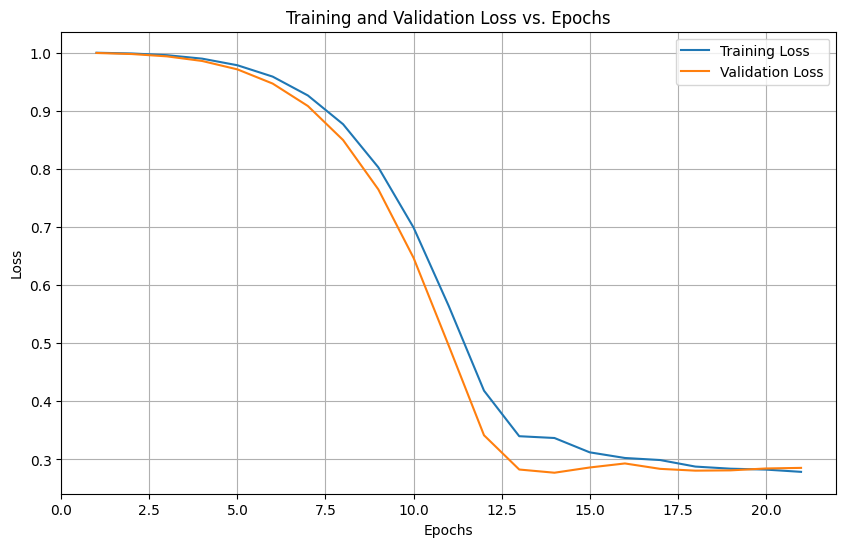

In [ ]:
epochs = range(1, len(train_losses) + 1)  # Adjust epochs to match train_losses length (no of epochs actually ran)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Prediction

A method for generating predictions and saving them in a csv file.

Parameters:
1. CGM data test csv file path
2. Demographic data test csv file path
3. CGMPreprocessor class
4. Fitted demo_processor pipeline from training
5. device(default is cpu)
6. output file path to store the predictions

In [ ]:
def predict_calories(
    cgm_test_path,
    demo_test_path,
    model,
    cgm_preprocessor,     # CLASS CGMPreprocessor (not an instance)
    demo_preprocessor,    # FITTED sklearn pipeline from training
    device='cpu',
    output_path=None
):
    # ===== STEP 1: Process CGM Test Data using CGMPreprocessor =====
    cgm_test_proc = cgm_preprocessor(cgm_test_path, pad_sequences=True)
    df_cgm_test = cgm_test_proc.get_processed_data()

    # ===== STEP 2: Process Demographic Test Data =====
    df_demo_test = pd.read_csv(demo_test_path)
    subject_ids = df_demo_test['Subject ID'].copy()
    X_demo_test = df_demo_test.drop(columns=['Subject ID'])

    # Use the pre-fit pipeline to transform the test data
    X_demo_transformed = demo_preprocessor.transform(X_demo_test)

    # Create a DataFrame with processed demographic features
    df_demo_transformed = pd.DataFrame(X_demo_transformed)
    df_demo_transformed.insert(0, 'Subject ID', subject_ids)

    # ===== STEP 3: Merge and convert to tensors =====
    merged = df_cgm_test.merge(df_demo_transformed, on='Subject ID', how='inner')
    # Get only columns that came from the transformed demo features
    demo_cols = df_demo_transformed.columns.drop('Subject ID').tolist()

    # Convert CGM values to tensor and reshape to (B, 1, T)
    cgm_tensor = torch.FloatTensor(np.stack(merged['CGM Values Norm'].values)).to(device)
    cgm_tensor = cgm_tensor.unsqueeze(2).permute(0, 2, 1)  # shape: (B, 1, T)

    # Demographic tensor
    demo_tensor = torch.FloatTensor(merged[demo_cols].values.astype(float)).to(device)

    # ===== STEP 4: Predict =====
    model.eval()
    with torch.no_grad():
        preds = model(cgm_tensor, demo_tensor).squeeze().cpu().numpy()

    # ===== STEP 5: Output (Create submission DataFrame) =====
    submission_df = pd.DataFrame({
        "row_id": np.arange(len(preds)),
        "label": preds
    })

    # Save to CSV if output_path is provided
    if output_path:
        submission_df.to_csv(output_path, index=False)

    # Return the submission DataFrame
    return submission_df


1. Please include your file paths for CGM_data_csv_test_file and Demographic_data_csv_test_file.

2. Please upload best_model.pt file before running the below code cell

3. Please upload all the related file to the colab

4. Please run the data preprocessing code cells with train data before predictions.


In [ ]:
# Loading the best model
model.load_state_dict(torch.load("best_model.pt"))

# Predict on test data
test_predictions = predict_calories(
    cgm_test_path="cgm_test.csv",
    demo_test_path="demo_viome_test.csv",
    model=model,
    cgm_preprocessor=CGMPreprocessor,  # The class
    demo_preprocessor=demo_preprocessor,  # the fitted sklearn ColumnTransformer
    device="cuda" if torch.cuda.is_available() else "cpu",
    output_path="submission.csv"
)


In [ ]:
test_predictions.head()

,row_id,label
0,0,1153.810303
1,1,997.806763
2,2,923.079834
3,3,1015.478516
4,4,913.334595
